In [1]:
import jax
import jax.numpy as jnp
from jax import jit
import numpy as np
import optax
from flax.training import train_state
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from soap_jax import soap
import jaxmetric as jm
from jaxmetric import models

In [2]:
isQuint = True
simple_eval = True

In [3]:
key = jax.random.PRNGKey(0)

if isQuint:
    psi=0
    k_mod = [1]
    proj_facts = (4,)
    poly = jit(lambda x: x[0]**5 + x[1]**5 + x[2]**5 +x[3]**5 + x[4]**5 + psi* x[0]*x[1]*x[2]*x[3]*x[4])

else:
    proj_facts = (1,1,1,1)
    k_mod = [1,1,1,1]
    psi0 = 0.5
    psi1 = 1.
    import itertools
    combinations = list(itertools.product([0, 1], repeat=4))
    @jit
    def poly(x):
        X = jnp.array([x[0],x[1]])
        Y = jnp.array([x[2],x[3]])
        U = jnp.array([x[4],x[5]])
        V = jnp.array([x[6],x[7]])
        term_sum = 0
        term_prod = psi1 * (X[0] * Y[0] * U[0] * V[0]) * (X[1] * Y[1] * U[1] * V[1])
        for c in combinations:
            s = sum(c)
            term_sum += (1-s%2)*(X[c[0]] * Y[c[1]] * U[c[2]] * V[c[3]])**2. + psi0*(s%2)*(X[c[0]] * Y[c[1]] * U[c[2]] * V[c[3]])**2.

        return term_prod + term_sum

In [4]:
# points = jm.point_gen.generate_points_calabi_yau(key, proj_facts,poly,5e5)


# with open("500kPointsPsiEq0.pkl", "wb") as f:
#     pickle.dump(points, f)

if isQuint:
    with open("cyMetPoints100kQuintic.pkl", "rb") as f:
        points = pickle.load(f)
else:
    with open("100kPointsTQ.pkl", "rb") as f:
        points = pickle.load(f)

print(jnp.shape(points))

(100005, 5)


In [5]:
# Initialize the model
if isQuint:
    model = models.FuncQuintic()
else:
    model = models.FuncTQ()

# Generate a PRNG key
key = jax.random.PRNGKey(np.random.randint(0,10**6))

# Initialize parameters
params = model.init(key,  jm.complex_numbers.complex_to_real(points[1]))

kappa_val = jm.metrics.kappa(proj_facts,k_mod, poly, points)

print(kappa_val)

(0.017587565-8.2464045e-14j)


In [6]:
# Split points into training and evaluation sets
split_ratio = 0.8
split_index = int(len(points) * split_ratio)
train_points = points[:split_index]
eval_points = points[split_index:]

def batch_data(data, batch_size):
    num_batches = len(data) // batch_size
    return jnp.array_split(data[:num_batches * batch_size], num_batches)

ptsBatched = batch_data(train_points, 64)

print(ptsBatched[0].shape,len(ptsBatched))
print(eval_points[0].shape,len(eval_points))

(64, 5) 1250
(5,) 20001


In [7]:
def replace_nan_grads(gradients, replacement_value=1e-8):
    def replace(grad):
        return jnp.where(jnp.isnan(grad), replacement_value, grad)
    
    return jax.tree_util.tree_map(replace, gradients)

def nan_replacement_transform(replacement_value=1e-6):
    def init_fn(params):
        return ()
    
    def update_fn(updates, state, params=None):
        sanitized_updates = jax.tree_util.tree_map(
            lambda g: jnp.where(jnp.isnan(g), replacement_value, g),
            updates
        )
        return sanitized_updates, state
    
    return optax.GradientTransformation(init_fn, update_fn)

optimiser = optax.chain(
#optax.clip(1),
soap(learning_rate=1e-3),
#optax.clip_by_block_rms(1e-2),
#optax.adam(learning_rate=1e-3),
#nan_replacement_transform(1e-8)
)

my_state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optimiser)

grad_func = jax.jit(jax.value_and_grad(jm.losses.loss_ma,argnums=1),static_argnums=(0,2,4))

# Define the training step
@jax.jit
def train_step(state,x):
  loss, grads = grad_func(model, state.params,proj_facts,k_mod, poly,  kappa_val, x)
  state = state.apply_gradients(grads=grads)
  return state, loss

def evaluate_step(state,x,scalar_num=100):
  loss = jm.losses.loss_ma(model, state.params,proj_facts,k_mod, poly, kappa_val, x)
  scalar =  jnp.mean(jnp.abs(jm.metrics.ricci_scalar(model, state.params, proj_facts, k_mod, poly, x[:scalar_num])))
  return loss, scalar

evaluate_step = jax.jit(evaluate_step,static_argnames=("scalar_num",))

@jax.jit
def evaluate_step_simple(state,x):
  loss = jm.losses.loss_ma(model, state.params,proj_facts,k_mod, poly, kappa_val, x)
  return loss

In [8]:
# Train the model
if simple_eval:
  eval = evaluate_step_simple(my_state,eval_points)
else:
  scalr_val = 100
  eval, scal = evaluate_step(my_state,eval_points,scalar_num=scalr_val)
  scalar = [[0,scal]]

loss = []
lossEval = [[0,eval]]
pbar = tqdm(range(10))
batchNum = len(ptsBatched)
pbar.set_description(f"Last Eval Loss {eval} | Batch {0}/{batchNum+1}  | Batch Loss: NA")

for i in pbar:
  order = np.array(range(batchNum))
  np.random.shuffle(order)
  k=1
  for j in order:
    k+=1
    my_state, l = train_step(my_state, ptsBatched[j])
    if k % 10 == 0:
      pbar.set_description(f"Last Eval Loss {eval} | Batch {k}/{batchNum+1}  | Batch Loss: {l}" )
    loss.append(l)
  if simple_eval:
    eval = evaluate_step_simple(my_state,eval_points)
  else:
    eval, scal = evaluate_step(my_state,eval_points,scalar_num=scalr_val)
    scalar.append([(i+1)*batchNum,scal])
  lossEval.append([(i+1)*batchNum,eval])

Last Eval Loss 1.5105913877487183 | Batch 700/1251  | Batch Loss: 0.862366259098053:   2%|▏         | 1/50 [00:31<25:33, 31.29s/it]  


KeyboardInterrupt: 

In [9]:
lossEval=jnp.array(lossEval)
loss = jnp.array(loss)
if not simple_eval:
  scalar = jnp.array(scalar)

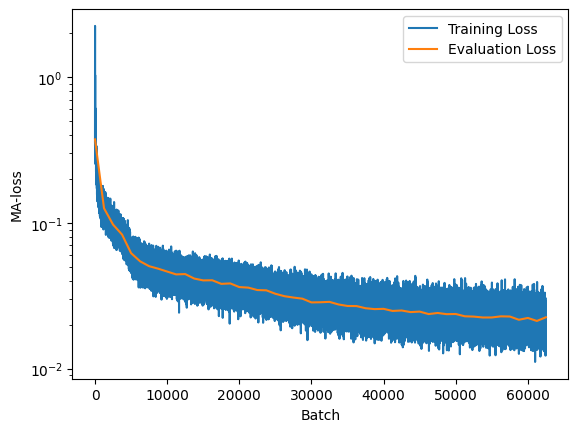

In [ ]:
plt.plot(loss, label='Training Loss')
plt.plot(lossEval[:,0], lossEval[:,1], label='Evaluation Loss')
# plt.plot(scalar[:,0], scalar[:,1], label='Scalar')
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('Batch')
plt.ylabel('MA-loss')
plt.legend()
plt.show()

In [ ]:
if not simple_eval:
  plt.plot(scalar[:,0], scalar[:,1], label='Scalar')
  plt.xlabel('Batch')
  plt.ylabel('Ricci Scalar')
  plt.yscale('log')
  plt.legend()
  plt.show()